## 4. Regression Analysis 

In [1]:
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sys
import seaborn as sns
import statsmodels.api as sm

module_path = '{}\\'.format(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..')))
sys.path.append(module_path)
from analysis.predictive.rnn_model.pipeline import load_data

from feature_engineering import feature_engineer

%matplotlib inline

# Read data from the data folder
file_directory = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '')) + '\\'
horse_race_df = pd.read_csv(file_directory + 'data/processed/horse_race.csv', low_memory=False, index_col=0)
horse_race_df['age_int'] = horse_race_df['sex_age'].apply(lambda x: re.search(r'\d+', x).group(0)).astype(int)

# Do some simple data transformation
horse_race_df['run_date'] = horse_race_df['run_date'].apply(pd.Timestamp)
horse_race_df = horse_race_df.sort_values(['horse_id', 'run_date'])
try:
    first_occur_df = pd.read_csv(file_directory + 'data/processed/first_occurrence_race.csv', low_memory=False, index_col=0)
    first_occur_df['run_date'] = first_occur_df['run_date'].apply(pd.Timestamp)
    first_occur_df = first_occur_df.sort_values(['horse_id', 'run_date'])
except FileNotFoundError:
    horse_race_sorted = horse_race_df.copy()
    horse_id_set = set()
    first_occur_dict = {}
    for index, value in horse_race_sorted.iterrows():
        if value['horse_id'] not in horse_id_set:
            horse_id_set.add(value['horse_id'])
            first_occur_dict[index] = value
    first_occur_df = pd.DataFrame.from_dict(first_occur_dict, orient='index')
    first_occur_df.to_csv(file_directory + 'data/processed/first_occurrence_race.csv', encoding='utf-8')
    
columns_to_drop = [
    'race', 'title', 'horse', 'sex_age',
    'distance', 'run_time', 'breeder',
    'jockey', 'margin', 'trainer_x', 'trainer_y', 'owner_x', 'owner_y', 'horse_name', 'date_of_birth', 
    'transaction_price', 'prize_obtained', 'race_record', 'highlight_race', 'relatives', 'status', 'prize'
]
for column in columns_to_drop:
    try:
        first_occur_df.drop(column, axis=1, inplace=True)
        horse_race_df.drop(column, axis=1, inplace=True)
    except ValueError:
        continue
        
horse_race_df = horse_race_df[horse_race_df['finishing_position'].apply(lambda x: bool(re.search(r'\d+', x)))]
horse_race_df['finishing_position'] = horse_race_df['finishing_position'].apply(lambda x: re.search(r'\d+', x).group(0))
horse_race_df['finishing_position'] = horse_race_df['finishing_position'].astype(int)

C:\Users\terry\Anaconda3\lib\site-packages\cmocean\tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
C:\Users\terry\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 4.1 Feature Engineering 

In [ ]:
# Functions have been moved to feature_engineering.py for code reuse
# See feature_engineering.py for more function details

if 1 == 0:
    # TODO: Check parent information (70%+ missing values)
    columns_to_drop_again = ['run_date', 'horse_id', 'parents']
    new_df = first_occur_df[columns_to_drop_again].copy()

    target_columns = ['horse_id', 'date_of_birth', 'breeder_id', 'gender', 'breed', 'race_record']
    new_df['parent_id_1'] = new_df['parents'].apply(lambda x: x.split(' ')[0])
    new_df['parent_id_2'] = new_df['parents'].apply(lambda x: x.split(' ')[1])
    new_df.drop('parents', axis=1, inplace=True)
    new_df = new_df[new_df['parent_id_1'].isin(horse_df['horse_id'].astype(str))]
    new_df = new_df[new_df['parent_id_2'].isin(horse_df['horse_id'].astype(str))]

    new_df.tail()

## 4.2 Regression Analysis

### 4.2.1 OLS for First Occurence Race

In [3]:
new_df_first = feature_engineer(first_occur_df)
X_first = new_df_first.loc[:, new_df_first.columns != 'run_time_1000']
y_first = new_df_first.loc[:, 'run_time_1000']
X_first = sm.add_constant(X_first)
results = sm.OLS(y_first, X_first).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          run_time_1000   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     251.2
Date:                Wed, 21 Mar 2018   Prob (F-statistic):               0.00
Time:                        21:00:51   Log-Likelihood:            -1.3500e+05
No. Observations:               67877   AIC:                         2.704e+05
Df Residuals:                   67667   BIC:                         2.723e+05
Df Model:                         209                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 28.3096      5.014      5.646      0.000      18.481      38.138
jockey_weight                          0.0728      0.008      9.072      0.000       0.057       0.089
win_odds                               0.0001      0.000      1.235      0.217    -8.8e-05       0.000
win_fav                                0.1164      0.003     42.317      0.000       0.111       0.122
horse_weight                           0.0072      0.000     28.183      0.000       0.007       0.008
curr_age                              -0.5052      0.026    -19.176      0.000      -0.557      -0.454
horse_weight_increase                 -0.0463      0.002    -19.674      0.000      -0.051      -0.042
age_stated                             0.3357      0.017     19.369      0.000       0.302       0.370
jockey_age                            -0.0039      0.001     -3.412      0.001      -0.006      -0.002
trainer_age                           -0.0018      0.001     -1.741      0.082      -0.004       0.000
year_minus_one                         0.0153      0.003      6.128      0.000       0.010       0.020
first_last_year_jockey                -0.0114      0.009     -1.230      0.219      -0.030       0.007
second_last_year_jockey                0.0010      0.007      0.146      0.884      -0.012       0.014
third_last_year_jockey                 0.0013      0.007      0.197      0.844      -0.012       0.014
out_last_year_jockey                   0.0024      0.006      0.373      0.709      -0.010       0.015
races_major_last_year_jockey           0.0034      0.007      0.513      0.608      -0.010       0.016
wins_major_last_year_jockey           -0.0059      0.005     -1.223      0.221      -0.015       0.004
races_special_last_year_jockey        -0.0011      0.007     -0.161      0.872      -0.014       0.012
wins_special_last_year_jockey         -0.0043      0.004     -1.137      0.255      -0.012       0.003
races_flat_last_year_jockey           -0.0003      0.007     -0.039      0.969      -0.013       0.013
wins_flat_last_year_jockey            -0.0012      0.004     -0.326      0.745      -0.008       0.006
races_grass_last_year_jockey          -0.0023      0.002     -1.321      0.186      -0.006       0.001
wins_grass_last_year_jockey            0.0176      0.010      1.740      0.082      -0.002       0.037
races_dirt_last_year_jockey           -0.0020      0.002     -1.142      0.253      -0.005       0.001
wins_dirt_last_year_jockey             0.0158      0.010      1.572      0.116      -0.004       0.035
wins_percent_last_year_jockey         -0.9366      0.730     -1.283      0.199      -2.367       0.494
wins_percent_2nd_last_year_jockey      0.7075      0.696      1.017      0.309      -0.656      

### 4.2.2 OLS for Full Race

In [4]:
new_df_full = feature_engineer(horse_race_df)
X_full = new_df_full.loc[:, new_df_full.columns != 'run_time_1000']
y_full = new_df_full.loc[:, 'run_time_1000']
X_full = sm.add_constant(X_full)
results = sm.OLS(y_full, X_full).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          run_time_1000   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     4471.
Date:                Wed, 21 Mar 2018   Prob (F-statistic):               0.00
Time:                        21:02:53   Log-Likelihood:            -1.2947e+06
No. Observations:              677627   AIC:                         2.590e+06
Df Residuals:                  677417   BIC:                         2.592e+06
Df Model:                         209                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 69.1192      1.090     63.431      0.000      66.983      71.255
jockey_weight                          0.0138      0.002      7.619      0.000       0.010       0.017
win_odds                               0.0013   3.21e-05     40.439      0.000       0.001       0.001
win_fav                                0.0735      0.001    101.091      0.000       0.072       0.075
horse_weight                           0.0021   7.79e-05     27.495      0.000       0.002       0.002
curr_age                              -0.5277      0.006    -89.737      0.000      -0.539      -0.516
horse_weight_increase                 -0.0085      0.000    -20.118      0.000      -0.009      -0.008
age_stated                             0.2998      0.006     53.842      0.000       0.289       0.311
jockey_age                            -0.0004      0.000     -1.312      0.189      -0.001       0.000
trainer_age                           -0.0036      0.000    -11.757      0.000      -0.004      -0.003
year_minus_one                        -0.0169      0.001    -23.351      0.000      -0.018      -0.015
first_last_year_jockey                -0.0085      0.003     -3.159      0.002      -0.014      -0.003
second_last_year_jockey               -0.0030      0.002     -1.480      0.139      -0.007       0.001
third_last_year_jockey                -0.0019      0.002     -0.964      0.335      -0.006       0.002
out_last_year_jockey                  -0.0023      0.002     -1.197      0.231      -0.006       0.001
races_major_last_year_jockey           0.0032      0.002      1.613      0.107      -0.001       0.007
wins_major_last_year_jockey           -0.0028      0.001     -1.977      0.048      -0.006   -2.48e-05
races_special_last_year_jockey         0.0033      0.002      1.662      0.097      -0.001       0.007
wins_special_last_year_jockey         -0.0026      0.001     -2.382      0.017      -0.005      -0.000
races_flat_last_year_jockey            0.0035      0.002      1.774      0.076      -0.000       0.007
wins_flat_last_year_jockey            -0.0030      0.001     -2.860      0.004      -0.005      -0.001
races_grass_last_year_jockey          -0.0009      0.000     -2.077      0.038      -0.002   -5.07e-05
wins_grass_last_year_jockey            0.0087      0.003      3.121      0.002       0.003       0.014
races_dirt_last_year_jockey           -0.0014      0.000     -3.202      0.001      -0.002      -0.001
wins_dirt_last_year_jockey             0.0099      0.003      3.572      0.000       0.004       0.015
wins_percent_last_year_jockey          0.0551      0.222      0.248      0.804      -0.381       0.491
wins_percent_2nd_last_year_jockey      0.3422      0.239      1.431      0.152      -0.126      

In [5]:
horse_race_df_grp_by = horse_race_df.set_index(['horse_id', 'run_date'])
horse_race_df_grp_by['run_time_diff'] = horse_race_df_grp_by['run_time_1000'].diff()
horse_race_df_grp_by = horse_race_df_grp_by[~horse_race_df_grp_by.index.isin(first_occur_df.set_index(['horse_id', 
                                                                                                       'run_date']).index)]
horse_race_df_grp_by.reset_index(inplace=True)
new_df_full_diff = feature_engineer(horse_race_df_grp_by)
new_df_full_diff['last_run_time'] = new_df_full_diff['run_time_1000'] - new_df_full_diff['run_time_diff']
new_df_full_diff.drop('run_time_diff', inplace=True, axis=1)

X_full_diff = new_df_full_diff.loc[:, new_df_full_diff.columns != 'run_time_1000']
y_full_diff = new_df_full_diff.loc[:, 'run_time_1000']
X_full_diff = sm.add_constant(X_full_diff)
results_diff = sm.OLS(y_full_diff, X_full_diff).fit()
results_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          run_time_1000   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     5398.
Date:                Wed, 21 Mar 2018   Prob (F-statistic):               0.00
Time:                        21:04:45   Log-Likelihood:            -1.1116e+06
No. Observations:              609756   AIC:                         2.224e+06
Df Residuals:                  609545   BIC:                         2.226e+06
Df Model:                         210                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 53.1278      1.058     50.220      0.000      51.054      55.201
jockey_weight                          0.0052      0.002      3.019      0.003       0.002       0.009
win_odds                               0.0009   3.08e-05     27.837      0.000       0.001       0.001
win_fav                                0.0424      0.001     60.333      0.000       0.041       0.044
horse_weight                       -4.406e-06   7.61e-05     -0.058      0.954      -0.000       0.000
curr_age                              -0.2664      0.006    -45.528      0.000      -0.278      -0.255
horse_weight_increase                  0.0016      0.000      3.851      0.000       0.001       0.002
age_stated                             0.1364      0.006     24.459      0.000       0.126       0.147
jockey_age                            -0.0003      0.000     -0.808      0.419      -0.001       0.000
trainer_age                           -0.0021      0.000     -7.221      0.000      -0.003      -0.002
year_minus_one                        -0.0146      0.001    -20.835      0.000      -0.016      -0.013
first_last_year_jockey                -0.0055      0.003     -2.136      0.033      -0.011      -0.000
second_last_year_jockey               -0.0023      0.002     -1.197      0.231      -0.006       0.001
third_last_year_jockey                -0.0012      0.002     -0.623      0.533      -0.005       0.003
out_last_year_jockey                  -0.0019      0.002     -1.008      0.313      -0.006       0.002
races_major_last_year_jockey           0.0015      0.002      0.784      0.433      -0.002       0.005
wins_major_last_year_jockey           -0.0024      0.001     -1.700      0.089      -0.005       0.000
races_special_last_year_jockey         0.0025      0.002      1.323      0.186      -0.001       0.006
wins_special_last_year_jockey         -0.0012      0.001     -1.086      0.278      -0.003       0.001
races_flat_last_year_jockey            0.0024      0.002      1.277      0.201      -0.001       0.006
wins_flat_last_year_jockey            -0.0020      0.001     -1.985      0.047      -0.004   -2.49e-05
races_grass_last_year_jockey          -0.0003      0.000     -0.699      0.484      -0.001       0.001
wins_grass_last_year_jockey            0.0049      0.003      1.813      0.070      -0.000       0.010
races_dirt_last_year_jockey           -0.0009      0.000     -2.182      0.029      -0.002   -9.19e-05
wins_dirt_last_year_jockey             0.0063      0.003      2.351      0.019       0.001       0.011
wins_percent_last_year_jockey          0.2002      0.216      0.927      0.354      -0.223       0.623
wins_percent_2nd_last_year_jockey      0.2436      0.236      1.030      0.303      -0.220      

In [15]:
# Get data
train, test, validation = load_data()
combined = train.append(test).append(validation)
combined = combined.drop(list(filter(lambda x: 'y_run_' in x and x != 'y_run_time_1000', combined.columns)), axis=1)
combined = combined.loc[combined['last_run_time'] != 0]
corr = combined.corr()

[2018-04-07 00:22:32,071] Stored datasets found...
[2018-04-07 00:22:33,631] Training: 2000-01-08 10:00:00 -> 2014-07-27 13:10:00
[2018-04-07 00:22:33,633] Testing: 2014-07-27 13:20:00 -> 2016-11-19 13:35:00
[2018-04-07 00:22:33,635] Validation: 2016-11-19 13:45:00 -> 2018-02-18 16:25:00


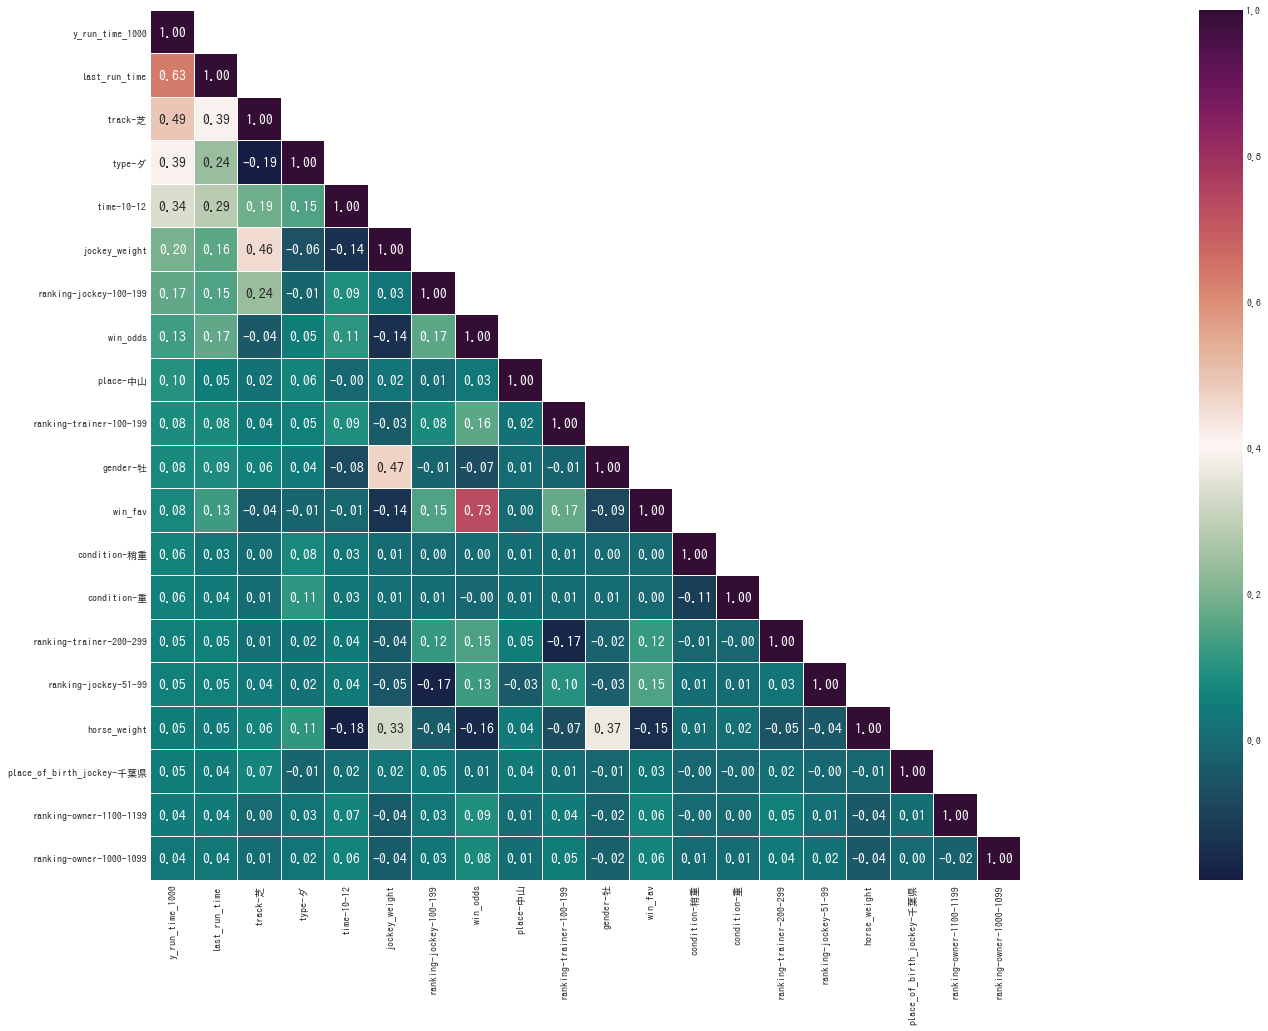

In [45]:
# Plot correlation
cols = corr.nlargest(20, 'y_run_time_1000')['y_run_time_1000'].index
cm = np.corrcoef(combined[cols].values.T)
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, 0)
with sns.axes_style("white"):
    mpl.rcParams['figure.figsize'] = (64.0, 16.0)
    plt.rcParams['font.family'] = 'IPAGothic'
    sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', linewidths=.1, annot_kws={"size": 14},
                yticklabels=cols.values, xticklabels=cols.values, cmap=cmocean.cm.curl, mask=mask)